### 1、数据降噪及特征提取

In [1]:
import pandas as pd 
import numpy as np
import glob,os
import math
from scipy.fftpack import fft,ifft


# 数据降噪
def de_noising(data):
    #对强度信号进行傅里叶变换
    sig=fft(data)
    #为了滤除高频噪声信号，采用截断函数可以做到这一点
    #根据傅里叶变换的结果设置合适的截断函数
    m=len(sig)
    n=250#设置截断范围，FFT谱上的信号主要集中在250Hz以下和的频段
    cutfun=np.ones([m,1])
    cutfun[20:m-20]=0
    ss =sig
    ss[n:m-n]=0 #对傅里叶变换信号做截断
    f=ifft(ss) #逆傅里叶变换
    real_f=np.real(f) #取实部

    return real_f

#特征提取
def  psfeature(data):
    
    #均值
    df_mean = data.mean()
    #标准差
    df_std = data.std()
    #均方根
    df_rms = math.sqrt(pow(df_mean,2) + pow(df_std,2))
    #峭度
    df_kurt = data.kurt()
    #波形因子
    df_boxing = (df_rms) / (abs(data).mean())
    #峰值因子
    df_fengzhi = (max(data)) / (df_rms)
    #脉冲因子
    df_maichong = (max(data)) / (abs(data).mean())
    m,n = 0,0
    for i in data:
        m += math.sqrt(abs(i))
        n +=1
    #裕度因子
    df_yudu = (df_rms) / (m/n)
    sum1,sum2,sum3=0,0,0
    for i in data:
        sum1 += i * (df_mean)
        sum2 += pow(i,2)
        sum3 += pow((df_mean),2)
    #重心频率
    df_zhongxinf = (sum1) / ((sum2) * math.pi * 2)
    #均方频率
    df_msf = (sum3)/((sum2) * pow(math.pi * 2,2))
    #频率方差   
    df_vf = (df_msf) - pow((df_zhongxinf),2)
    feature_list = [df_mean,df_std,df_rms,df_kurt,df_boxing,df_fengzhi,df_maichong,df_yudu,df_zhongxinf,df_msf,df_vf]
    return feature_list 

# 各轴承特征提取写入本地csv
def psfeature_tocsv(path):
    '''
    参数path为一个文件夹
    无返回值，结果直接写入本地csv文件中
    '''

    # 轴承名称
    name_ = os.path.split(path)[1]
    # 读取轴承所有采样点数据
    file = glob.glob(os.path.join(path, "acc*.csv"))
    # 统计该轴承的采样次数
    number = len(file)

    file_name1 = []                   
    psfeature1 = []
    psfeature2 = []
    rul = []
    
    n=0#初始化采样点位置
    for f in file:
        df = pd.read_csv(f,sep=',|;',header=None)
        #print(df[4].head())#水平振动信号
        #print(df[5].head())#垂直振动信号
        n += 1#当前采样点  
        life = 1-n/number#当前采样节点可使用寿命
        file_name1.append(name_)
    #     数据降噪
        df[4] = de_noising(df[4])
        df[5] = de_noising(df[5])
    #     特征提取
        psfeature1.append(psfeature(df[4]))
        psfeature2.append(psfeature(df[5]))    
        rul.append(life)


    column_name = ['file_name','df_mean_r','df_std_r','df_rms_r','df_kurt_r','df_boxing_r','df_fengzhi_r','df_maichong_r','df_yudu_r','df_zhongxinf_r',
    'df_msf_r','df_vf_r','df_mean_l','df_std_l','df_rms_l','df_kurt_l','df_boxing_l','df_fengzhi_l','df_maichong_l','df_yudu_l',
    'df_zhongxinf_l','df_msf_l','df_vf_l','rul']

    psfeature_ = pd.concat([pd.DataFrame(file_name1),pd.DataFrame(psfeature1),pd.DataFrame(psfeature2),pd.DataFrame(rul)],axis=1)

    psfeature_.columns = column_name

    psfeature_.to_csv('E:\lunwen\dataset3\data'+name_[7:]+'.csv',index=False)


# 读取本地原始数据
path = r'E:\lunwen\FEMTOBearingDataSet\Validation_Set\Full_Test_Set'
files = glob.glob(os.path.join(path, "Bearing*"))


for file in files:
    psfeature_tocsv(file)


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


### 2、特征选择

In [3]:
from minepy import MINE
import matplotlib.pyplot as plt
path = r'E:\lunwen\dataset3'
file = glob.glob(os.path.join(path, "data*.csv"))
data_ = []
for f in file:
    df = pd.read_csv(f)
    data_.append(df)
data = pd.concat(data_)

x = data.iloc[:,1:23]
y = data.iloc[:,[23]]

mine = MINE(alpha=0.6, c=15, est="mic_approx")
mic_ = []
col_name = []

for i in range(22):
    mine.compute_score(x.iloc[:,[i]].T.values[0], y.T.values[0])
    col_name.append(x.columns.values.tolist()[i])
    mic_.append(mine.mic())

print(pd.concat([pd.DataFrame(col_name),pd.DataFrame(mic_)],axis=1))
dict_ = dict(zip(col_name,mic_))

sort_ = dict(sorted(dict_.items(),key=lambda x:x[1],reverse=True))
# 特征重要性绘图
plt.figure(figsize=(10,6))

plt.ylabel('MIC',fontsize = 15,rotation = 90)
plt.xlabel('Feature',fontsize = 15)
plt.bar(sort_.keys(),sort_.values(), color='orange', align='center')
plt.xticks(rotation=-45)   # 设置x轴标签旋转角度    


                 0         0
0        df_mean_r  0.044163
1         df_std_r  0.178414
2         df_rms_r  0.179170
3        df_kurt_r  0.079111
4      df_boxing_r  0.079241
5     df_fengzhi_r  0.049203
6    df_maichong_r  0.053638
7        df_yudu_r  0.167793
8   df_zhongxinf_r  0.051765
9         df_msf_r  0.051765
10         df_vf_r  0.051759
11       df_mean_l  0.061748
12        df_std_l  0.170886
13        df_rms_l  0.169526
14       df_kurt_l  0.070616
15     df_boxing_l  0.073630
16    df_fengzhi_l  0.065418
17   df_maichong_l  0.063222
18       df_yudu_l  0.155339
19  df_zhongxinf_l  0.053337
20        df_msf_l  0.053337
21         df_vf_l  0.053337


NameError: name 'plt' is not defined

### 3、模型训练集测试

In [4]:
# 支持向量机模型进行学习和预测

from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV


path = r'E:\lunwen\dataset3'
file = glob.glob(os.path.join(path, "data1_1.csv"))
file2 = glob.glob(os.path.join(path, "data1_3.csv"))
data_ = []
# 训练集
for f in file:
    df = pd.read_csv(f)
    data_.append(df)
data_ = pd.concat(data_)
# 测试集
data_t = []
for f in file2:
    df = pd.read_csv(f)
    data_t.append(df)
data_t = pd.concat(data_t)

# 训练集
x=data_.loc[:,['df_std_r','df_rms_r','df_yudu_r','df_std_l','df_rms_l','df_yudu_l']]
y = data_.iloc[:,[23]]
# 测试集
x_t=data_t.loc[:,['df_std_r','df_rms_r','df_yudu_r','df_std_l','df_rms_l','df_yudu_l']]
y_t = data_t.iloc[:,[23]]


# 线性核函数配置支持向量机
linear_svr = SVR(kernel="linear")
# 训练
linear_svr.fit(x, y)
# 预测 保存预测结果
linear_svr_y_predict = linear_svr.predict(x_t)

# 多项式核函数配置支持向量机
poly_svr = SVR(kernel="poly")
# 训练
poly_svr.fit(x, y)
# 预测 保存预测结果
poly_svr_y_predict = poly_svr.predict(x_t)

# Sigmoid 核函数配置支持向量机
sig_svr = SVR(kernel="sigmoid")
# 训练
sig_svr.fit(x, y)
# 预测 保存预测结果
sig_svr_y_predict = sig_svr.predict(x_t)


# 径向基核函数配置支持向量机
rbf_svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
# 训练
rbf_svr.fit(x, y)
# 预测 保存预测结果
rbf_svr_y_predict = rbf_svr.predict(x_t)

# 模型评估
# 线性核函数 模型评估
print("线性核函数支持向量机的默认评估值为：", linear_svr.score(x_t, y_t))
print("线性核函数支持向量机的R_squared值为：", r2_score(y_t, linear_svr_y_predict))
print("线性核函数支持向量机的均方误差为:", mean_squared_error(y_t,linear_svr_y_predict))
print("线性核函数支持向量机的平均绝对误差为:", mean_absolute_error(y_t,linear_svr_y_predict))
# 对多项式核函数模型评估
print("对多项式核函数的默认评估值为：", poly_svr.score(x_t, y_t))
print("对多项式核函数的R_squared值为：", r2_score(y_t, poly_svr_y_predict))
print("对多项式核函数的均方误差为:", mean_squared_error(y_t,poly_svr_y_predict))
print("对多项式核函数的平均绝对误差为:", mean_absolute_error(y_t,poly_svr_y_predict))
# Sigmoid 核函数模型评估
print("Sigmoid核函数的默认评估值为：", sig_svr.score(x_t, y_t))
print("Sigmoid核函数的R_squared值为：", r2_score(y_t, sig_svr_y_predict))
print("Sigmoid核函数的均方误差为:", mean_squared_error(y_t,sig_svr_y_predict))
print("Sigmoid核函数的平均绝对误差为:", mean_absolute_error(y_t,sig_svr_y_predict))
# 径向基核函数模型评估
print("径向基核函数的默认评估值为：", rbf_svr.score(x_t, y_t))
print("径向基核函数的R_squared值为：", r2_score(y_t, rbf_svr_y_predict))
print("径向基核函数的均方误差为:", mean_squared_error(y_t,rbf_svr_y_predict))
print("径向基核函数的平均绝对误差为:", mean_absolute_error(y_t,rbf_svr_y_predict))

D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the

D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

线性核函数支持向量机的默认评估值为： -4.067634221836059
线性核函数支持向量机的R_squared值为： -4.067634221836059
线性核函数支持向量机的均方误差为: 0.42230277695157586
线性核函数支持向量机的平均绝对误差为: 0.3166587743568658
对多项式核函数的默认评估值为： -686.2771711661147
对多项式核函数的R_squared值为： -686.2771711661147
对多项式核函数的均方误差为: 57.27308744349687
对多项式核函数的平均绝对误差为: 0.9287936342485097
Sigmoid核函数的默认评估值为： -4826.658229896476
Sigmoid核函数的R_squared值为： -4826.658229896476
Sigmoid核函数的均方误差为: 402.304781168629
Sigmoid核函数的平均绝对误差为: 8.716615218698225
径向基核函数的默认评估值为： 0.8864452400439075
径向基核函数的R_squared值为： 0.8864452400439075
径向基核函数的均方误差为: 0.009462894985375062
径向基核函数的平均绝对误差为: 0.07501334629139514


### 模型评估

In [37]:
# 训练集
x=data_.loc[:,['df_std_r','df_rms_r','df_yudu_r','df_std_l','df_rms_l','df_yudu_l']]
y = data_.iloc[:,[23]]
# 线性核函数配置支持向量机
linear_svr = SVR(kernel="linear")
# 训练
linear_svr.fit(x, y)
# 预测 保存预测结果
linear_svr_y_predict = linear_svr.predict(x)

# 多项式核函数配置支持向量机
poly_svr = SVR(kernel="poly")
# 训练
poly_svr.fit(x, y)
# 预测 保存预测结果
poly_svr_y_predict = poly_svr.predict(x)

# Sigmoid 核函数配置支持向量机
sig_svr = SVR(kernel="sigmoid")
# 训练
sig_svr.fit(x, y)
# 预测 保存预测结果
sig_svr_y_predict = sig_svr.predict(x)


# 径向基核函数配置支持向量机
rbf_svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
# 训练
rbf_svr.fit(x, y)
# 预测 保存预测结果
rbf_svr_y_predict = rbf_svr.predict(x)

# 模型评估
# 线性核函数 模型评估
print("线性核函数支持向量机的默认评估值为：", linear_svr.score(x, y))
print("线性核函数支持向量机的R_squared值为：", r2_score(y, linear_svr_y_predict))
print("线性核函数支持向量机的均方误差为:", mean_squared_error(y,linear_svr_y_predict))
print("线性核函数支持向量机的平均绝对误差为:", mean_absolute_error(y,linear_svr_y_predict))
# 对多项式核函数模型评估
print("对多项式核函数的默认评估值为：", poly_svr.score(x, y))
print("对多项式核函数的R_squared值为：", r2_score(y, poly_svr_y_predict))
print("对多项式核函数的均方误差为:", mean_squared_error(y,poly_svr_y_predict))
print("对多项式核函数的平均绝对误差为:", mean_absolute_error(y,poly_svr_y_predict))
# Sigmoid 核函数模型评估
print("Sigmoid核函数的默认评估值为：", sig_svr.score(x, y))
print("Sigmoid核函数的R_squared值为：", r2_score(y, sig_svr_y_predict))
print("Sigmoid核函数的均方误差为:", mean_squared_error(y,sig_svr_y_predict))
print("Sigmoid核函数的平均绝对误差为:", mean_absolute_error(y,sig_svr_y_predict))
# 径向基核函数模型评估
print("径向基核函数的默认评估值为：", rbf_svr.score(x, y))
print("径向基核函数的R_squared值为：", r2_score(y, rbf_svr_y_predict))
print("径向基核函数的均方误差为:", mean_squared_error(y,rbf_svr_y_predict))
print("径向基核函数的平均绝对误差为:", mean_absolute_error(y,rbf_svr_y_predict))

D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the

D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

线性核函数支持向量机的默认评估值为： 0.8981980379253456
线性核函数支持向量机的R_squared值为： 0.8981980379253457
线性核函数支持向量机的均方误差为: 0.008483495759790863
线性核函数支持向量机的平均绝对误差为: 0.07213734190661857
对多项式核函数的默认评估值为： 0.7795055274851524
对多项式核函数的R_squared值为： 0.7795055274851524
对多项式核函数的均方误差为: 0.018374537037560187
对多项式核函数的平均绝对误差为: 0.10831599148089092
Sigmoid核函数的默认评估值为： -3182.562214152596
Sigmoid核函数的R_squared值为： -3182.562214152596
Sigmoid核函数的均方误差为: 265.2968174128944
Sigmoid核函数的平均绝对误差为: 6.320984943589632
径向基核函数的默认评估值为： 0.9783900512530733
径向基核函数的R_squared值为： 0.9783900512530733
径向基核函数的均方误差为: 0.001800828833037727
径向基核函数的平均绝对误差为: 0.03403737917602445


### 结果绘图

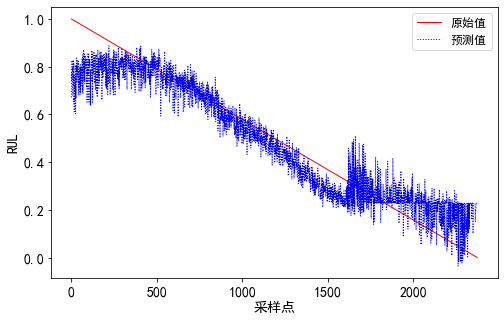

In [29]:
import matplotlib.pyplot as plt
import matplotlib
# 解决画图中文显示乱码
# matplotlib.use('qt4agg')
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False

x = np.arange(0,len(y_t))
x1 = np.arange(0,len(rbf_svr_y_predict))

#画散点图  
fig = plt.figure(figsize=(8,5))
# plt.scatter(x,y_t,s=5,c = 'r',marker = 'o',label='原始值')
# plt.scatter(x1,rbf_svr_y_predict,s=5,c = 'b',marker = '.',label='预测值')
plt.plot(x,y_t,linewidth = '1',c = 'r',label='原始值')
plt.plot(x1,rbf_svr_y_predict,linestyle=':',linewidth = '1',c = 'b',label='预测值')
# plt.tick_params(labelsize=20)
# plt.xlabel('采样点',fontsize = 20)
# plt.ylabel('RUL',fontsize = 20)
plt.tick_params(labelsize=14)
plt.xlabel('采样点',fontsize = 14)
plt.ylabel('RUL',fontsize = 14)
plt.legend(loc='upper right',prop={'size':12})
plt.show()

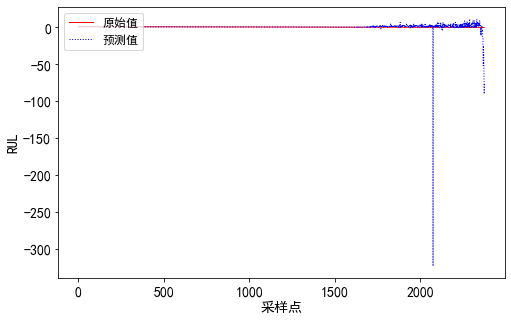

In [35]:

x = np.arange(0,len(y_t))
x1 = np.arange(0,len(poly_svr_y_predict))

#画散点图  
fig = plt.figure(figsize=(8,5))
plt.plot(x,y_t,linewidth = '1',c = 'r',label='原始值')
plt.plot(x1,poly_svr_y_predict,linestyle=':',linewidth = '1',c = 'b',label='预测值')
# 定义刻度范围
# plt.ylim(0,)
plt.tick_params(labelsize=14)
plt.xlabel('采样点',fontsize = 14)
plt.ylabel('RUL',fontsize = 14)
plt.legend(loc='upper left',prop={'size':12})
plt.show()